In [1]:
# %% Imports
from jax import random, numpy as jnp

from modax.data.burgers import burgers
from modax.models import DeepmodBayes, Deepmod
from modax.training import train_probabilistic, train, train_probabilistic_mse
from modax.linear_model.mask_estimator import ThresholdedLasso
from flax import optim

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%load_ext autoreload
%autoreload 2

In [2]:
# %% Making data
key = random.PRNGKey(42)

x = jnp.linspace(-3, 4, 50)
t = jnp.linspace(0.5, 5.0, 20)
t_grid, x_grid = jnp.meshgrid(t, x, indexing="ij")
u = burgers(x_grid, t_grid, 0.1, 1.0)

X = jnp.concatenate([t_grid.reshape(-1, 1), x_grid.reshape(-1, 1)], axis=1)
y = u.reshape(-1, 1)
y += 0.10 * jnp.std(y) * random.normal(key, y.shape)

# Baseline

In [96]:
from modax.losses import loss_fn_pinn_stateful

In [98]:
model = Deepmod([30, 30, 30, 1])
variables = model.init(key, X)

optimizer = optim.Adam(learning_rate=2e-3, beta1=0.99, beta2=0.99)
state, params = variables.pop("params")
optimizer = optimizer.create(params)

mask_fn = ThresholdedLasso(threshold=0.1)

In [102]:
optimizer, state = train(
    model,
    optimizer,
    state,
    loss_fn_pinn_stateful,
    mask_fn,
    X,
    y,
    max_epochs=1e4,
    split=0.8,
    rand_seed=42,
)

Loss step 0.0: 0.017135808244347572
Loss step 1000.0: 0.0001830585242714733


/home/gert-jan/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019119429634884, tolerance: 9.999998292187229e-05
  model = cd_fast.enet_coordinate_descent(


Loss step 2000.0: 0.00018156386795453727
Loss step 3000.0: 0.00017614390526432544
Loss step 4000.0: 0.00017252062389161438
Loss step 5000.0: 0.00016004795907065272
Converged at epoch 5836.0 with mask [[False]
 [False]
 [ True]
 [False]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]].


In [103]:
variables = {"params": optimizer.target, **state}
prediction = model.apply(variables, X, mutable=list(state.keys()))[0][0].reshape(x_grid.shape)

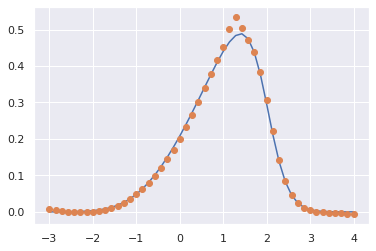

In [104]:
frame = 10
plt.plot(x, u[frame, :])
plt.plot(x, prediction[frame, :], 'o')

# MSE

## Grad

In [3]:
from modax.losses.bayesian import loss_fn_mse_grad

In [4]:
model = DeepmodBayes([30, 30, 30, 1])
variables = model.init(key, X)

optimizer = optim.Adam(learning_rate=2e-3, beta1=0.99, beta2=0.99)
state, params = variables.pop("params")
optimizer = optimizer.create(params)

In [5]:
# only train mse, stop at minimum mse testset
optimizer, state = train_probabilistic_mse(
    model,
    optimizer,
    state,
    loss_fn_mse_grad,
    X,
    y,
    max_epochs=1e4,
    split=0.8,
    rand_seed=42,
)

Loss step 0.0: 725.1221923828125
Loss step 1000.0: 525.1157836914062


In [6]:
variables = {"params": optimizer.target, **state}
prediction = model.apply(variables, X, mutable=list(state.keys()))[0][0].reshape(x_grid.shape)

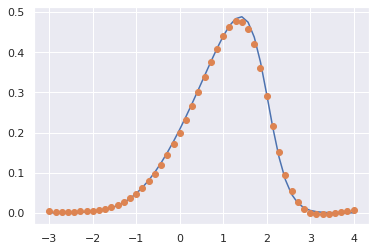

In [7]:
frame = 10
plt.plot(x, u[frame, :])
plt.plot(x, prediction[frame, :], 'o')

We see from tensorboard that mse reaches a minimum, but p_mse is not maximal yet; that's because tau hasn't converged yet.

## Precalc

In [10]:
from modax.losses.bayesian import loss_fn_mse_precalc

In [11]:
model = DeepmodBayes([30, 30, 30, 1])
variables = model.init(key, X)

optimizer = optim.Adam(learning_rate=2e-3, beta1=0.99, beta2=0.99)
state, params = variables.pop("params")
optimizer = optimizer.create(params)

In [12]:
# only train mse, stop at minimum mse testset
optimizer, state = train_probabilistic_mse(
    model,
    optimizer,
    state,
    loss_fn_mse_precalc,
    X,
    y,
    max_epochs=1e4,
    split=0.8,
    rand_seed=42,
)

Loss step 0.0: -55.43794631958008


In [13]:
variables = {"params": optimizer.target, **state}
prediction = model.apply(variables, X, mutable=list(state.keys()))[0][0].reshape(x_grid.shape)

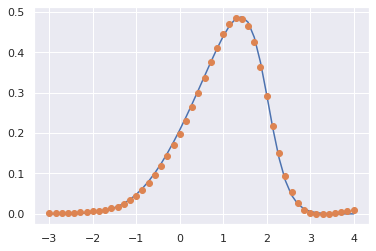

In [14]:
frame = 10
plt.plot(x, u[frame, :])
plt.plot(x, prediction[frame, :], 'o')

Now the two are perfectly aligned, and it doesn't matter whether we check the validation for the mse or p_mse, as it is (and should be) similar.

# Multitask

## Grad

In [75]:
from modax.losses.bayesian import loss_fn_multitask_grad

In [76]:
model = DeepmodBayes([30, 30, 30, 1])
variables = model.init(key, X)

optimizer = optim.Adam(learning_rate=2e-3, beta1=0.99, beta2=0.99)
state, params = variables.pop("params")
optimizer = optimizer.create(params)

mask_fn = ThresholdedLasso(threshold=0.1)

In [77]:
# only train mse, stop at minimum mse testset
optimizer, state = train_probabilistic(
    model,
    optimizer,
    state,
    loss_fn_multitask_grad,
    mask_fn,
    X,
    y,
    max_epochs=1e4,
    split=0.8,
    rand_seed=42,
)

Loss step 0.0: 1510.201416015625
Loss step 1000.0: 1110.20947265625
Loss step 2000.0: 910.2023315429688
Loss step 3000.0: 510.2184753417969
Loss step 4000.0: 110.36080932617188
Loss step 5000.0: -288.7017822265625
Loss step 6000.0: -681.9421997070312
Loss step 7000.0: -1033.44140625
Loss step 8000.0: -1244.39794921875
Loss step 9000.0: -1438.6051025390625


In [78]:
variables = {"params": optimizer.target, **state}
prediction = model.apply(variables, X, mutable=list(state.keys()))[0][0].reshape(x_grid.shape)

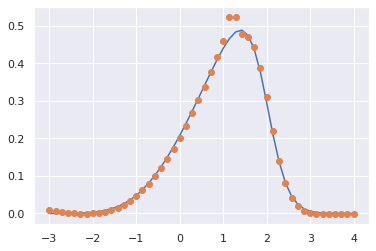

In [79]:
frame = 10
plt.plot(x, u[frame, :])
plt.plot(x, prediction[frame, :], 'o')

So it finds the right eq, but:
1. nu and tau are not converged 
2. if you run this for very long it'll explode cause nu -> infinity; we already see tau going down.

## Precalc

In [80]:
from modax.losses.bayesian import loss_fn_multitask_precalc

In [81]:
model = DeepmodBayes([30, 30, 30, 1])
variables = model.init(key, X)

optimizer = optim.Adam(learning_rate=2e-3, beta1=0.99, beta2=0.99)
state, params = variables.pop("params")
optimizer = optimizer.create(params)

mask_fn = ThresholdedLasso(threshold=0.1)

In [ ]:
# only train mse, stop at minimum mse testset
optimizer, state = train_probabilistic(
    model,
    optimizer,
    state,
    loss_fn_multitask_precalc,
    mask_fn,
    X,
    y,
    max_epochs=1e4,
    split=0.8,
    rand_seed=42,
)

In [83]:
variables = {"params": optimizer.target, **state}
prediction = model.apply(variables, X, mutable=list(state.keys()))[0][0].reshape(x_grid.shape)

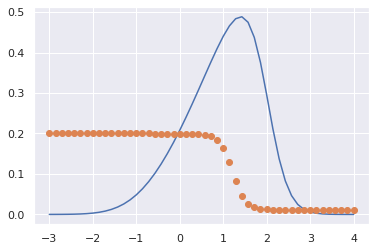

In [84]:
frame = 10
plt.plot(x, u[frame, :])
plt.plot(x, prediction[frame, :], 'o')

This is super bad. What happened? We see that it didn't learn the mse; by precalculating the precision it gets stuck.

# Bayesian multitask

now let's do bayesian. I have good experience with setting alpha = n_samples / 2, beta = 1 / (n_samples / 2 * 1e-4), but I haven't picked them carefully or optimized. We set an uninformative prior on the mse:

In [85]:
n_samples = X.shape[0]
prior_params_reg = (n_samples/2, n_samples/2 * 1e-4)
prior_params_mse = (0.0, 0.0)

## Grad

In [86]:
from modax.losses.bayesian import loss_fn_pinn_bayes_grad

In [87]:
model = DeepmodBayes([30, 30, 30, 1])
variables = model.init(key, X)

optimizer = optim.Adam(learning_rate=2e-3, beta1=0.99, beta2=0.99)
state, params = variables.pop("params")
optimizer = optimizer.create(params)

mask_fn = ThresholdedLasso(threshold=0.1)

In [88]:
# only train mse, stop at minimum mse testset
optimizer, state = train_probabilistic(
    model,
    optimizer,
    state,
    loss_fn_pinn_bayes_grad,
    mask_fn,
    X,
    y,
    max_epochs=1e4,
    split=0.8,
    rand_seed=42,
    prior_params_reg = prior_params_reg,
    prior_params_mse = prior_params_mse
)

Loss step 0.0: 4505.23291015625
Loss step 1000.0: 3109.31396484375
Loss step 2000.0: 2411.28564453125
Loss step 3000.0: 1015.3003540039062
Loss step 4000.0: -380.4397888183594
Loss step 5000.0: -1774.6619873046875
Loss step 6000.0: -3157.54736328125
Loss step 7000.0: -4458.22607421875
Loss step 8000.0: -5319.65283203125
Loss step 9000.0: -5364.75830078125


In [89]:
variables = {"params": optimizer.target, **state}
prediction = model.apply(variables, X, mutable=list(state.keys()))[0][0].reshape(x_grid.shape)

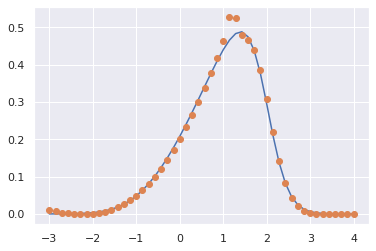

In [90]:
frame = 10
plt.plot(x, u[frame, :])
plt.plot(x, prediction[frame, :], 'o')

As expected we still get a good result.

## Precalc

In [91]:
from modax.losses.bayesian import loss_fn_pinn_bayes_typeII

In [92]:
model = DeepmodBayes([30, 30, 30, 1])
variables = model.init(key, X)

optimizer = optim.Adam(learning_rate=2e-3, beta1=0.99, beta2=0.99)
state, params = variables.pop("params")
optimizer = optimizer.create(params)

mask_fn = ThresholdedLasso(threshold=0.1)

In [93]:
# only train mse, stop at minimum mse testset
optimizer, state = train_probabilistic(
    model,
    optimizer,
    state,
    loss_fn_pinn_bayes_typeII,
    mask_fn,
    X,
    y,
    max_epochs=1e4,
    split=0.8,
    rand_seed=42,
    prior_params_reg = prior_params_reg,
    prior_params_mse = prior_params_mse
)

Loss step 0.0: -4401.35693359375
Loss step 1000.0: -5342.21484375
Loss step 2000.0: -5340.7548828125
Loss step 3000.0: -5342.6015625
Converged at epoch 3586.0 with mask [[False]
 [False]
 [ True]
 [False]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]].


In [94]:
variables = {"params": optimizer.target, **state}
prediction = model.apply(variables, X, mutable=list(state.keys()))[0][0].reshape(x_grid.shape)

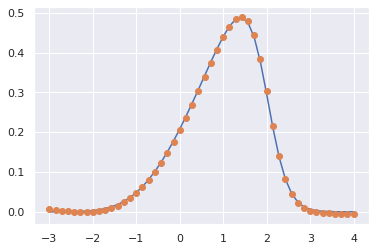

In [95]:
frame = 10
plt.plot(x, u[frame, :])
plt.plot(x, prediction[frame, :], 'o')

This does wonderfully well... and at this frame also better than the normal pinn?

Options to check:
1. Marginalizing over tau/nu to give students t, with a preset alpha / beta
2. Marginalizing over tau/nu and learn alpha / beta?